In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import nltk
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence #unique id

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, Embedding,GRU

import warnings
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_data = pd.read_csv("/content/Corona_NLP_train.csv",encoding = "latin1")
test_data = pd.read_csv("/content/Corona_NLP_test.csv",encoding = "latin1")

In [ ]:
train_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
test_data.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [ ]:
train_data.shape

(41157, 6)

In [ ]:
test_data.shape

(3798, 6)

In [ ]:

train_data = train_data[["OriginalTweet","Sentiment"]]
test_data = test_data[["OriginalTweet","Sentiment"]]

In [ ]:
train_data = train_data.sample(10000,random_state = 2)

In [ ]:
test_data = test_data.sample(2000,random_state = 2)

In [ ]:
train_data.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [ ]:
test_data.isnull().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [ ]:
train_data.head()

,OriginalTweet,Sentiment
20931,Every 1st responder( including the delivery pe...,Extremely Positive
34498,"Now more than ever, spot the #coronavirus scam...",Negative
4717,More than one in four Americans are actively a...,Extremely Negative
12499,?@BILD? newspaper posts images of #German chan...,Neutral
18112,Just sent my husband to the grocery store like...,Negative


In [ ]:
test_data.head()

,OriginalTweet,Sentiment
849,if you live in a heavily COVID-19 affected are...,Negative
1208,Apparently the #Covid_19 virus causes excessiv...,Negative
3503,I work in retail part time and the amount of p...,Extremely Negative
558,COVID-19... School closures... Univ. classes s...,Negative
2044,"On a serious note tho, why the hell are us guy...",Negative


In [ ]:
#Cleaning the text
import re
import nltk
from nltk.corpus import stopwords
all_stopwords = stopwords.words('english')
all_stopwords.remove('not')
nltk.download('omw-1.4')

def preprocessor(data):
    corpus = []
    for i in data.index:
      #remove urls
      tweet1= re.sub(r'http\S+', ' ', data['OriginalTweet'][i])
      #remove html tags
      tweet2 = re.sub(r'<.*?>',' ', tweet1) 
      #remove digits
      tweet3 = re.sub(r'\d+',' ', tweet2)
      #remove hashtags
      tweet4 = re.sub(r'#\w+',' ', tweet3)
      review = re.sub('[^a-zA-Z]', ' ', tweet4)
      review = review.lower()
      review = review.split()
      wl = WordNetLemmatizer()
      review = [wl.lemmatize(word) for word in review if word not in all_stopwords]
      review = ' '.join(review)
      corpus.append(review)
    return corpus

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:


#Transforming the OriginalTweet 
train_data["OriginalTweet"] = preprocessor(train_data)
test_data["OriginalTweet"] = preprocessor(test_data)

In [ ]:
test_data["OriginalTweet"]

849     live heavily covid affected area cannot afford...
1208    apparently virus cause excessive bowel movemen...
3503    work retail part time amount people store week...
558     covid school closure univ class shifting onlin...
2044    serious note tho hell u guy go work still casu...
                              ...                        
41      far pennsylvanian reached office report inflat...
1081    food left grocery store look pumpkin spice thi...
422     drastic effect sick elderly one want visit iso...
2870    message emergency stock non perishable food mi...
2894    covid update new financial responsibility flex...
Name: OriginalTweet, Length: 2000, dtype: object

In [ ]:
train_data["OriginalTweet"]

20931    every st responder including delivery people g...
34498                                       ever spot scam
4717     one four american actively avoiding eating res...
12499    bild newspaper post image chancellor shopping ...
18112            sent husband grocery store like going war
                               ...                        
31871    vernonglittle z danieldumbrill tweet stamp lie...
18136    talking brother going grocery store temperatur...
38473    many favorite independent shop store chicago d...
10038    study bcg powered explore consumer shifting sp...
18057              enjoying using christmas boris bog roll
Name: OriginalTweet, Length: 10000, dtype: object

In [ ]:
train_data["Sentiment"].value_counts()

Positive              2819
Negative              2393
Neutral               1880
Extremely Positive    1610
Extremely Negative    1298
Name: Sentiment, dtype: int64

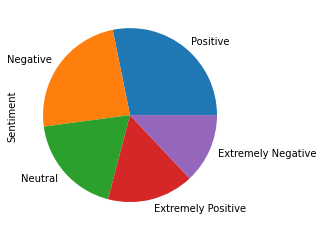

In [ ]:
train_data["Sentiment"].value_counts().plot(kind="pie")

In [ ]:
test_data["Sentiment"].value_counts()

Negative              533
Positive              487
Neutral               350
Extremely Negative    322
Extremely Positive    308
Name: Sentiment, dtype: int64

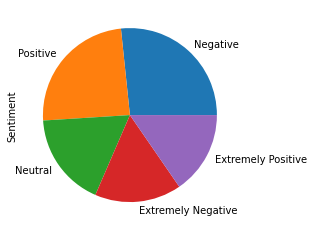

In [ ]:
test_data["Sentiment"].value_counts().plot(kind="pie")

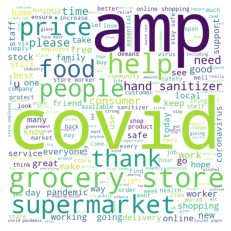

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(width = 800,height = 800,background_color = "white",min_font_size = 10)
wc.generate(" ".join(train_data[train_data["Sentiment"]== "Extremely Positive"]["OriginalTweet"]))
plt.imshow(wc)
plt.axis("off")
plt.show()

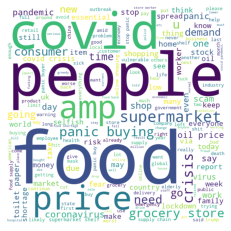

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(width = 800,height = 800,background_color = "white",min_font_size = 10)
wc.generate(" ".join(train_data[train_data["Sentiment"]== "Extremely Negative"]["OriginalTweet"]))
plt.imshow(wc)
plt.axis("off")
plt.show()

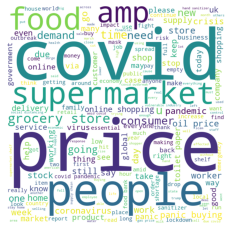

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(width = 800,height = 800,background_color = "white",min_font_size = 10)
wc.generate(" ".join(train_data[train_data["Sentiment"]== "Negative"]["OriginalTweet"]))
plt.imshow(wc)
plt.axis("off")
plt.show()

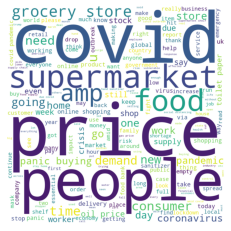

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(width = 800,height = 800,background_color = "white",min_font_size = 10)
wc.generate(" ".join(train_data[train_data["Sentiment"]== "Negative"]["OriginalTweet"]))
plt.imshow(wc)
plt.axis("off")
plt.show()

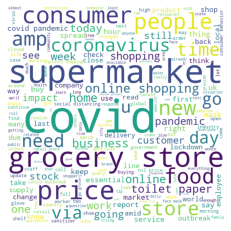

In [ ]:
from wordcloud import WordCloud
wc = WordCloud(width = 800,height = 800,background_color = "white",min_font_size = 10)
wc.generate(" ".join(train_data[train_data["Sentiment"]== "Neutral"]["OriginalTweet"]))
plt.imshow(wc)
plt.axis("off")
plt.show()

In [ ]:
train_data["Sentiment"] = train_data["Sentiment"].replace({"Extremely Negative":0,"Negative":0,"Neutral":2,"Positive":1,"Extremely Positive":1})
test_data["Sentiment"] = test_data["Sentiment"].replace({"Extremely Negative":0,"Negative":0,"Neutral":2,"Positive":1,"Extremely Positive":1})
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=10000) #You will get 31750 columns if you dont specify max_features
X_train = cv.fit_transform(train_data["OriginalTweet"]).toarray()
y_train = train_data["Sentiment"]
X_test = cv.transform(test_data["OriginalTweet"]).toarray()
y_test = test_data['Sentiment']

In [ ]:
X_train.shape

(10000, 10000)

In [ ]:
y_train.shape

(10000,)

In [ ]:
X_test.shape

(2000, 10000)

In [ ]:

y_test.shape

(2000,)

In [ ]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBRFClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

In [ ]:
def models(model):
    model.fit(X_train,y_train)
    pred = model.predict(X_test)
    
    train = model.score(X_train,y_train)
    test = model.score(X_test,y_test)
    print(f"train : {train}\ntest : {test}\nclassification_report :\n{classification_report(y_test,pred)}\n Accuracy_Score :\n{accuracy_score(y_test,pred)}")

In [ ]:
models(RandomForestClassifier())

train : 1.0
test : 0.701
classification_report :
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       855
           1       0.71      0.75      0.73       795
           2       0.60      0.61      0.60       350

    accuracy                           0.70      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.70      0.70      0.70      2000

 Accuracy_Score :
0.701


In [ ]:
models(SVC())

train : 0.9436
test : 0.6975
classification_report :
              precision    recall  f1-score   support

           0       0.78      0.66      0.71       855
           1       0.68      0.78      0.73       795
           2       0.57      0.60      0.59       350

    accuracy                           0.70      2000
   macro avg       0.68      0.68      0.68      2000
weighted avg       0.70      0.70      0.70      2000

 Accuracy_Score :
0.6975


In [ ]:
models(AdaBoostClassifier())

train : 0.6196
test : 0.5975
classification_report :
              precision    recall  f1-score   support

           0       0.75      0.55      0.63       855
           1       0.76      0.56      0.64       795
           2       0.36      0.81      0.50       350

    accuracy                           0.60      2000
   macro avg       0.62      0.64      0.59      2000
weighted avg       0.69      0.60      0.61      2000

 Accuracy_Score :
0.5975


In [ ]:
from sklearn.naive_bayes import MultinomialNB
models(MultinomialNB())

train : 0.8293
test : 0.652
classification_report :
              precision    recall  f1-score   support

           0       0.69      0.74      0.71       855
           1       0.62      0.77      0.69       795
           2       0.58      0.17      0.27       350

    accuracy                           0.65      2000
   macro avg       0.63      0.56      0.56      2000
weighted avg       0.64      0.65      0.63      2000

 Accuracy_Score :
0.652


In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
models(LogisticRegression())

train : 0.98
test : 0.7545
classification_report :
              precision    recall  f1-score   support

           0       0.81      0.75      0.78       855
           1       0.76      0.80      0.78       795
           2       0.62      0.65      0.64       350

    accuracy                           0.75      2000
   macro avg       0.73      0.74      0.73      2000
weighted avg       0.76      0.75      0.76      2000

 Accuracy_Score :
0.7545


In [ ]:
sentlen = []
for sent in train_data["OriginalTweet"]:
  sentlen.append(len(word_tokenize(sent)))  # we are using the word tokenize to split the sentences in words 

train_data["SentLen"] = sentlen 
train_data.head()

,OriginalTweet,Sentiment,SentLen
20931,every st responder including delivery people g...,1,22
34498,ever spot scam,0,3
4717,one four american actively avoiding eating res...,0,13
12499,bild newspaper post image chancellor shopping ...,2,8
18112,sent husband grocery store like going war,0,7


In [ ]:
sentlen = []
for sent in test_data["OriginalTweet"]:
  sentlen.append(len(word_tokenize(sent)))  # we are using the word tokenize to split the sentences in words 

test_data["SentLen"] = sentlen 
test_data.head()

,OriginalTweet,Sentiment,SentLen
849,live heavily covid affected area cannot afford...,0,27
1208,apparently virus cause excessive bowel movemen...,0,27
3503,work retail part time amount people store week...,0,15
558,covid school closure univ class shifting onlin...,0,27
2044,serious note tho hell u guy go work still casu...,0,25


In [ ]:
max_len = np.quantile(sentlen, 0.95)

In [ ]:
max_len

27.0

In [ ]:
tok = Tokenizer(char_level=False, split=" ")
tok.fit_on_texts(train_data["OriginalTweet"])
tok.index_word

{1: 'covid',
 2: 'price',
 3: 'store',
 4: 'supermarket',
 5: 'food',
 6: 'grocery',
 7: 'people',
 8: 'amp',
 9: 'consumer',
 10: 'not',
 11: 'shopping',
 12: 'online',
 13: 'time',
 14: 'need',
 15: 'u',
 16: 'get',
 17: 'worker',
 18: 'pandemic',
 19: 'hand',
 20: 'panic',
 21: 'go',
 22: 'like',
 23: 'demand',
 24: 'home',
 25: 'help',
 26: 'sanitizer',
 27: 'coronavirus',
 28: 'day',
 29: 'stock',
 30: 'one',
 31: 'going',
 32: 'supply',
 33: 'week',
 34: 'work',
 35: 'buying',
 36: 'new',
 37: 'crisis',
 38: 'mask',
 39: 'please',
 40: 'due',
 41: 'toilet',
 42: 'paper',
 43: 'local',
 44: 'shelf',
 45: 'keep',
 46: 'good',
 47: 'delivery',
 48: 'oil',
 49: 'make',
 50: 'essential',
 51: 'business',
 52: 'today',
 53: 'buy',
 54: 'via',
 55: 'stay',
 56: 'many',
 57: 'take',
 58: 'shop',
 59: 'still',
 60: 'say',
 61: 'see',
 62: 'market',
 63: 'know',
 64: 'employee',
 65: 'outbreak',
 66: 'social',
 67: 'would',
 68: 'way',
 69: 'virus',
 70: 'stop',
 71: 'thing',
 72: 'staff',

In [ ]:
_vocab_len = len(tok.index_word)
_vocab_len

17211

In [ ]:
len(train_data)

10000

In [ ]:
seqtrain = tok.texts_to_sequences(train_data["OriginalTweet"]) #step1
seqtrain[0]

[110,
 680,
 661,
 306,
 47,
 7,
 6,
 3,
 699,
 238,
 17,
 169,
 758,
 1698,
 18,
 16,
 105,
 1343,
 165,
 2039,
 867,
 194]

In [ ]:
seqmattrain = sequence.pad_sequences(seqtrain, maxlen= int(max_len)) #step2
seqmattrain[0]

array([   0,    0,    0,    0,    0,  110,  680,  661,  306,   47,    7,
          6,    3,  699,  238,   17,  169,  758, 1698,   18,   16,  105,
       1343,  165, 2039,  867,  194], dtype=int32)

In [ ]:
seqtest = tok.texts_to_sequences(test_data["OriginalTweet"])
seqmattest = sequence.pad_sequences(seqtest, maxlen=int(max_len))
seqmattest

array([[   0,  239, 2445, ...,   25,  106,    7],
       [   0,    0,  937, ..., 1052, 1195,   69],
       [   0,    0,    0, ...,  612,    1, 2203],
       ...,
       [   0,    0,    0, ...,  375,  133,  291],
       [   0,    0,    0, ..., 1974,    6,   70],
       [   0,    0,    0, ...,   18,   96, 2612]], dtype=int32)

In [ ]:
_vocab_len

17211

In [ ]:
max_len

27.0

In [ ]:
rnn = Sequential()

rnn.add(Embedding(_vocab_len+1,700, input_length=int(max_len), mask_zero=True))
rnn.add(SimpleRNN(units=32, activation="tanh"))
rnn.add(Dense(units=32, activation="relu"))
rnn.add(Dropout(0.2))

rnn.add(Dense(units = 3,activation = "softmax"))

rnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics = ["acc"])

rnn.fit(seqmattrain, y_train, batch_size=50, epochs=50)

ypred = rnn.predict(seqmattest)

ypred = np.argmax(ypred,axis =1)

Epoch 1/50
200/200 [==============================] - 30s 143ms/step - loss: 0.8696 - acc: 0.5889
Epoch 2/50
200/200 [==============================] - 29s 144ms/step - loss: 0.3195 - acc: 0.8910
Epoch 3/50
200/200 [==============================] - 29s 145ms/step - loss: 0.0830 - acc: 0.9743
Epoch 4/50
200/200 [==============================] - 28s 141ms/step - loss: 0.0243 - acc: 0.9946
Epoch 5/50
200/200 [==============================] - 29s 147ms/step - loss: 0.0133 - acc: 0.9969
Epoch 6/50
200/200 [==============================] - 28s 142ms/step - loss: 0.0150 - acc: 0.9965
Epoch 7/50
200/200 [==============================] - 29s 143ms/step - loss: 0.0100 - acc: 0.9975
Epoch 8/50
200/200 [==============================] - 28s 142ms/step - loss: 0.0132 - acc: 0.9954
Epoch 9/50
200/200 [==============================] - 29s 143ms/step - loss: 0.0467 - acc: 0.9856
Epoch 10/50
200/200 [==============================] - 28s 143ms/step - loss: 0.0439 - acc: 0.9848
Epoch 11/50
200/200

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred))
print("Accuracy_Score: \n",accuracy_score(y_test, ypred))

              precision    recall  f1-score   support

           0       0.67      0.63      0.65       855
           1       0.63      0.68      0.65       795
           2       0.48      0.46      0.47       350

    accuracy                           0.62      2000
   macro avg       0.59      0.59      0.59      2000
weighted avg       0.62      0.62      0.62      2000

Accuracy_Score: 
 0.6185


In [ ]:
rnn = Sequential()

rnn.add(Embedding(_vocab_len+1,700, input_length=int(max_len), mask_zero=True))

rnn.add(LSTM(units=32, activation="tanh"))
rnn.add(Dense(units=32, activation="relu"))
rnn.add(Dropout(0.2))

rnn.add(Dense(units = 3,activation = "softmax"))

rnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics = ["acc"])

rnn.fit(seqmattrain, y_train, batch_size=50, epochs=50)

ypred = rnn.predict(seqmattest)

ypred = np.argmax(ypred,axis =1)

Epoch 1/50
200/200 [==============================] - 39s 171ms/step - loss: 0.8103 - acc: 0.6383
Epoch 2/50
200/200 [==============================] - 34s 170ms/step - loss: 0.3456 - acc: 0.8857
Epoch 3/50
200/200 [==============================] - 34s 169ms/step - loss: 0.1540 - acc: 0.9543
Epoch 4/50
200/200 [==============================] - 34s 168ms/step - loss: 0.0825 - acc: 0.9765
Epoch 5/50
200/200 [==============================] - 35s 173ms/step - loss: 0.0530 - acc: 0.9850
Epoch 6/50
200/200 [==============================] - 34s 169ms/step - loss: 0.0314 - acc: 0.9917
Epoch 7/50
200/200 [==============================] - 34s 171ms/step - loss: 0.0180 - acc: 0.9954
Epoch 8/50
200/200 [==============================] - 34s 169ms/step - loss: 0.0169 - acc: 0.9955
Epoch 9/50
200/200 [==============================] - 34s 169ms/step - loss: 0.0114 - acc: 0.9970
Epoch 10/50
200/200 [==============================] - 34s 168ms/step - loss: 0.0142 - acc: 0.9957
Epoch 11/50
200/200

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred))
print("Accuracy_Score: \n",accuracy_score(y_test, ypred))

              precision    recall  f1-score   support

           0       0.77      0.72      0.75       855
           1       0.73      0.79      0.76       795
           2       0.61      0.59      0.60       350

    accuracy                           0.73      2000
   macro avg       0.70      0.70      0.70      2000
weighted avg       0.73      0.73      0.73      2000

Accuracy_Score: 
 0.7265


In [ ]:
rnn = Sequential()

rnn.add(Embedding(_vocab_len+1,700, input_length=int(max_len), mask_zero=True))

rnn.add(GRU(units=32, activation="tanh"))
rnn.add(Dense(units=32, activation="relu"))
rnn.add(Dropout(0.2))

rnn.add(Dense(units = 3,activation = "softmax"))

rnn.compile(optimizer="adam", loss="sparse_categorical_crossentropy",metrics = ["acc"])

rnn.fit(seqmattrain, y_train, batch_size=50, epochs=50)

ypred = rnn.predict(seqmattest)

ypred = np.argmax(ypred,axis =1)

Epoch 1/50
200/200 [==============================] - 35s 160ms/step - loss: 0.8599 - acc: 0.5974
Epoch 2/50
200/200 [==============================] - 32s 161ms/step - loss: 0.3795 - acc: 0.8741
Epoch 3/50
200/200 [==============================] - 32s 161ms/step - loss: 0.1817 - acc: 0.9429
Epoch 4/50
200/200 [==============================] - 33s 167ms/step - loss: 0.1030 - acc: 0.9708
Epoch 5/50
200/200 [==============================] - 33s 165ms/step - loss: 0.0552 - acc: 0.9840
Epoch 6/50
200/200 [==============================] - 32s 160ms/step - loss: 0.0398 - acc: 0.9892
Epoch 7/50
200/200 [==============================] - 32s 161ms/step - loss: 0.0289 - acc: 0.9923
Epoch 8/50
200/200 [==============================] - 32s 161ms/step - loss: 0.0215 - acc: 0.9946
Epoch 9/50
200/200 [==============================] - 32s 159ms/step - loss: 0.0111 - acc: 0.9969
Epoch 10/50
200/200 [==============================] - 32s 160ms/step - loss: 0.0075 - acc: 0.9981
Epoch 11/50
200/200

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred))
print("Accuracy_Score: \n",accuracy_score(y_test, ypred))

              precision    recall  f1-score   support

           0       0.74      0.77      0.75       855
           1       0.73      0.71      0.72       795
           2       0.64      0.59      0.61       350

    accuracy                           0.72      2000
   macro avg       0.70      0.69      0.70      2000
weighted avg       0.72      0.72      0.72      2000

Accuracy_Score: 
 0.7185
